# Variational inference in Bayesian neural networks

In [1]:
import tensorflow, tensorflow_probability
print(tensorflow.__version__)
print(tensorflow.keras.__version__)
print(tensorflow_probability.__version__)

2.3.0
2.4.0
0.11.0


```
2.3.0, 2.4.0, 0.11.0
```

This article demonstrates how to implement and train a Bayesian neural network with Keras following the approach described in [Weight Uncertainty in Neural Networks](https://arxiv.org/abs/1505.05424) (*Bayes by Backprop*). The implementation is kept simple for illustration purposes and uses Keras 2.2.4 and Tensorflow 1.12.0. For more advanced implementations of Bayesian methods for neural networks consider using [Tensorflow Probability](https://www.tensorflow.org/probability), for example.

Bayesian neural networks differ from plain neural networks in that their weights are assigned a probability distribution instead of a single value or point estimate. These probability distributions describe the uncertainty in weights and can be used to estimate uncertainty in predictions. Training a Bayesian neural network via variational inference learns the parameters of these distributions instead of the weights directly.

## Probabilistic model

A neural network can be viewed as probabilistic model $p(y \lvert \mathbf{x},\mathbf{w})$. For classification, $y$ is a set of classes and $p(y \lvert \mathbf{x},\mathbf{w})$ is a categorical distribution. For regression, $y$ is a continuous variable and $p(y \lvert \mathbf{x},\mathbf{w})$ is a Gaussian distribution. 

Given a training dataset $\mathcal{D} = \left\{\mathbf{x}^{(i)}, y^{(i)}\right\}$ we can construct the likelihood function $p(\mathcal{D} \lvert \mathbf{w}) = \prod_i p(y^{(i)} \lvert \mathbf{x}^{(i)}, \mathbf{w})$ which is a function of parameters $\mathbf{w}$. Maximizing the likelihood function gives the maximimum likelihood estimate (MLE) of $\mathbf{w}$. The usual optimization objective during training is the negative log likelihood. For a categorical distribution this is the *cross entropy* error function, for a Gaussian distribution this is proportional to the *sum of squares* error function. MLE can lead to severe overfitting though.

Multiplying the likelihood with a prior distribution $p(\mathbf{w})$ is, by Bayes theorem, proportional to the posterior distribution $p(\mathbf{w} \lvert \mathcal{D}) \propto p(\mathcal{D} \lvert \mathbf{w}) p(\mathbf{w})$. Maximizing $p(\mathcal{D} \lvert \mathbf{w}) p(\mathbf{w})$ gives the maximum a posteriori (MAP) estimate of $\mathbf{w}$. Computing the MAP estimate has a regularizing effect and can prevent overfitting. The optimization objectives here are the same as for MLE plus a regularization term coming from the log prior.

Both MLE and MAP give point estimates of parameters. If we instead had a full posterior distribution over parameters we could make predictions that take weight uncertainty into account. This is covered by the posterior predictive distribution $p(y \lvert \mathbf{x},\mathcal{D}) = \int p(y \lvert \mathbf{x}, \mathbf{w}) p(\mathbf{w} \lvert \mathcal{D}) d\mathbf{w}$ in which the parameters have been marginalized out. This is equivalent to averaging predictions from an ensemble of neural networks weighted by the posterior probabilities of their parameters $\mathbf{w}$. 

## Variational inference

Unfortunately, an analytical solution for the posterior $p(\mathbf{w} \lvert \mathcal{D})$ in neural networks is untractable. We therefore have to approximate the true posterior with a variational distribution $q(\mathbf{w} \lvert \boldsymbol{\theta})$ of known functional form whose parameters we want to estimate. This can be done by minimizing the [Kullback-Leibler divergence](https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence) between $q(\mathbf{w} \lvert \boldsymbol{\theta})$ and the true posterior $p(\mathbf{w} \lvert \mathcal{D})$  w.r.t. to $\boldsymbol{\theta}$. As shown in [Appendix](#Appendix), the corresponding optimization objective or cost function is

$$
\mathcal{F}(\mathcal{D},\boldsymbol{\theta}) = 
\mathrm{KL}(q(\mathbf{w} \lvert \boldsymbol{\theta}) \mid\mid p(\mathbf{w})) -
\mathbb{E}_{q(\mathbf{w} \lvert \boldsymbol{\theta})} \log p(\mathcal{D} \lvert \mathbf{w})
\tag{1}
$$

This is known as the *variational free energy*. The first term is the Kullback-Leibler divergence between the variational distribution $q(\mathbf{w} \lvert \boldsymbol{\theta})$ and the prior $p(\mathbf{w})$ and is called the *complexity cost*. The second term is the expected value of the likelihood w.r.t. the variational distribution and is called the *likelihood cost*. By re-arranging the KL term, the cost function can also be written as 

$$
\mathcal{F}(\mathcal{D},\boldsymbol{\theta}) = 
\mathbb{E}_{q(\mathbf{w} \lvert \boldsymbol{\theta})} \log q(\mathbf{w} \lvert \boldsymbol{\theta}) -
\mathbb{E}_{q(\mathbf{w} \lvert \boldsymbol{\theta})} \log p(\mathbf{w}) -
\mathbb{E}_{q(\mathbf{w} \lvert \boldsymbol{\theta})} \log p(\mathcal{D} \lvert \mathbf{w})
\tag{2}
$$

We see that all three terms in equation $2$ are expectations w.r.t. the variational distribution $q(\mathbf{w} \lvert \boldsymbol{\theta})$. The cost function can therefore be approximated by drawing samples $\mathbf{w}^{(i)}$ from $q(\mathbf{w} \lvert \boldsymbol{\theta})$.

$$
\mathcal{F}(\mathcal{D},\boldsymbol{\theta}) \approx {1 \over N} \sum_{i=1}^N \left[
\log q(\mathbf{w}^{(i)} \lvert \boldsymbol{\theta}) -
\log p(\mathbf{w}^{(i)}) -
\log p(\mathcal{D} \lvert \mathbf{w}^{(i)})\right]
\tag{3}
$$


In the following example, we'll use a Gaussian distribution for the variational posterior, parameterized by $\boldsymbol{\theta} = (\boldsymbol{\mu}, \boldsymbol{\sigma})$ where $\boldsymbol{\mu}$ is the mean vector of the distribution and $\boldsymbol{\sigma}$ the standard deviation vector. The elements of $\boldsymbol{\sigma}$ are the elements of a diagonal covariance matrix which means that weights are assumed to be uncorrelated. Instead of parameterizing the neural network with weights $\mathbf{w}$ directly we parameterize it with $\boldsymbol{\mu}$ and $\boldsymbol{\sigma}$ and therefore double the number of parameters compared to a plain neural network. 

## Network training

A training iteration consists of a forward-pass and and backward-pass. During a forward pass a single sample is drawn from the variational posterior distribution. It is used to evaluate the approximate cost function defined by equation $3$. The first two terms of the cost function are data-independent and can be evaluated layer-wise, the last term is data-dependent and is evaluated at the end of the forward-pass. During a backward-pass, gradients of $\boldsymbol{\mu}$ and $\boldsymbol{\sigma}$ are calculated via backpropagation so that their values can be updated by an optimizer.

Since a forward pass involves a stochastic sampling step we have to apply the so-called *re-parameterization trick* for backpropagation to work. The trick is to sample from a parameter-free distribution and then transform the sampled $\boldsymbol{\epsilon}$ with a deterministic function $t(\boldsymbol{\mu}, \boldsymbol{\sigma}, \boldsymbol{\epsilon})$ for which a gradient can be defined. Here, $\boldsymbol{\epsilon}$ is drawn from a standard normal distribution i.e. $\boldsymbol{\epsilon} \sim \mathcal{N}(\mathbf{0}, \mathbf{I})$ and function $t(\boldsymbol{\mu}, \boldsymbol{\sigma}, \boldsymbol{\epsilon}) = \boldsymbol{\mu} + \boldsymbol{\sigma} \odot \boldsymbol{\epsilon}$ shifts the sample by mean $\boldsymbol{\mu}$ and scales it with $\boldsymbol{\sigma}$ where $\odot$ is element-wise multiplication.

For numeric stability we will parameterize the network with $\boldsymbol{\rho}$ instead of $\boldsymbol{\sigma}$ directly and transform $\boldsymbol{\rho}$ with the softplus function to obtain $\boldsymbol{\sigma} = \log(1 + \exp(\boldsymbol{\rho}))$. This ensures that $\boldsymbol{\sigma}$ is always positive. As prior, a scale mixture of two Gaussians is used $p(\mathbf{w}) = \pi \mathcal{N}(\mathbf{w} \lvert 0,\sigma_1^2) + (1 - \pi) \mathcal{N}(\mathbf{w} \lvert 0,\sigma_2^2)$ where $\sigma_1$, $\sigma_2$ and $\pi$ are hyper-parameters i.e. they are not learned during training.

## Uncertainty characterization

Uncertainty in predictions that arise from the uncertainty in weights is called [epistemic uncertainty](https://en.wikipedia.org/wiki/Uncertainty_quantification). This kind of uncertainty can be reduced if we get more data. Consequently,  epistemic uncertainty is higher in regions of no or little training data and lower in regions of more training data. Epistemic uncertainty is covered by the variational posterior distribution. Uncertainty coming from the inherent noise in training data is an example of [aleatoric uncertainty](https://en.wikipedia.org/wiki/Uncertainty_quantification). It cannot be reduced if we get more data. Aleatoric uncertainty is covered by the probability distribution used to define the likelihood function. 

## Implementation example

Variational inference of neural network parameters is now demonstrated on a simple regression problem. We therefore use a Gaussian distribution for $p(y \lvert \mathbf{x},\mathbf{w})$. The training dataset consists of 32 noisy samples `X`, `y` drawn from a sinusoidal function.

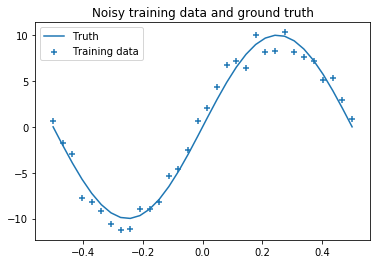

In [2]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

def f(x, sigma):
    epsilon = np.random.randn(*x.shape) * sigma
    return 10 * np.sin(2 * np.pi * (x)) + epsilon

train_size = 32
noise = 1.0

X = np.linspace(-0.5, 0.5, train_size).reshape(-1, 1)
y = f(X, sigma=noise)
y_true = f(X, sigma=0.0)

plt.scatter(X, y, marker='+', label='Training data')
plt.plot(X, y_true, label='Truth')
plt.title('Noisy training data and ground truth')
plt.legend()

In [3]:
X.shape, y.shape

((32, 1), (32, 1))

The noise in training data gives rise to aleatoric uncertainty. To cover epistemic uncertainty we implement the variational inference logic in a custom `DenseVariational` Keras layer. The complexity cost (`kl_loss`) is computed layer-wise and added to the total loss with the `add_loss` method. Implementations of `build` and `call` directly follow the equations defined above. 

In [4]:
from tensorflow.keras import backend as K
from tensorflow.keras import activations, initializers
from tensorflow.keras.layers import Layer

import tensorflow as tf
import tensorflow_probability as tfp


class DenseVariational(Layer):
    def __init__(self,
                 units,
                 kl_weight,
                 activation=None,
                 prior_sigma_1=1.5,
                 prior_sigma_2=0.1,
                 prior_pi=0.5, **kwargs):
        self.units = units
        self.kl_weight = kl_weight
        self.activation = activations.get(activation)
        self.prior_sigma_1 = prior_sigma_1
        self.prior_sigma_2 = prior_sigma_2
        self.prior_pi_1 = prior_pi
        self.prior_pi_2 = 1.0 - prior_pi
        self.init_sigma = np.sqrt(self.prior_pi_1 * self.prior_sigma_1 ** 2 +
                                  self.prior_pi_2 * self.prior_sigma_2 ** 2)

        super().__init__(**kwargs)

    def compute_output_shape(self, input_shape):
        return input_shape[0], self.units

    def build(self, input_shape):
        self.kernel_mu = self.add_weight(name='kernel_mu',
                                         shape=(input_shape[1], self.units),
                                         initializer=initializers.RandomNormal(stddev=self.init_sigma),
                                         trainable=True)
        self.bias_mu = self.add_weight(name='bias_mu',
                                       shape=(self.units,),
                                       initializer=initializers.RandomNormal(stddev=self.init_sigma),
                                       trainable=True)
        self.kernel_rho = self.add_weight(name='kernel_rho',
                                          shape=(input_shape[1], self.units),
                                          initializer=initializers.constant(0.0),
                                          trainable=True)
        self.bias_rho = self.add_weight(name='bias_rho',
                                        shape=(self.units,),
                                        initializer=initializers.constant(0.0),
                                        trainable=True)
        super().build(input_shape)

    def call(self, inputs, **kwargs):
        kernel_sigma = tf.math.softplus(self.kernel_rho)
        kernel = self.kernel_mu + kernel_sigma * tf.random.normal(self.kernel_mu.shape)

        bias_sigma = tf.math.softplus(self.bias_rho)
        bias = self.bias_mu + bias_sigma * tf.random.normal(self.bias_mu.shape)

        self.add_loss(self.kl_loss(kernel, self.kernel_mu, kernel_sigma) +
                      self.kl_loss(bias, self.bias_mu, bias_sigma))

        return self.activation(K.dot(inputs, kernel) + bias)

    def kl_loss(self, w, mu, sigma):
        variational_dist = tfp.distributions.Normal(mu, sigma)
        return self.kl_weight * K.sum(variational_dist.log_prob(w) - self.log_prior_prob(w))

    def log_prior_prob(self, w):
        comp_1_dist = tfp.distributions.Normal(0.0, self.prior_sigma_1)
        comp_2_dist = tfp.distributions.Normal(0.0, self.prior_sigma_2)
        return K.log(self.prior_pi_1 * comp_1_dist.prob(w) +
                     self.prior_pi_2 * comp_2_dist.prob(w))

Our model is a neural network with two `DenseVariational` hidden layers, each having 20 units, and one `DenseVariational` output layer with one unit. Instead of modeling a full probability distribution $p(y \lvert \mathbf{x},\mathbf{w})$ as output the network simply outputs the mean of the corresponding Gaussian distribution. In other words, we do not model aleatoric uncertainty here and assume it is known. We only model epistemic uncertainty via the `DenseVariational` layers.

Since the training dataset has only 32 examples we train the network with all 32 examples per epoch so that the number of batches per epoch is 1. For other configurations, the complexity cost (`kl_loss`) must be weighted by $1/M$ as described in section 3.4 of the paper where $M$ is the number of mini-batches per epoch. The hyper-parameter values for the mixture prior, `prior_params`, have been chosen to work well for this example and may need adjustments in another context.

As prior, a scale mixture of two Gaussians is used $p(\mathbf{w}) = \pi \mathcal{N}(\mathbf{w} \lvert 0,\sigma_1^2) + (1 - \pi) \mathcal{N}(\mathbf{w} \lvert 0,\sigma_2^2)$ where $\sigma_1$, $\sigma_2$ and $\pi$ are hyper-parameters i.e. they are not learned during training.

In [5]:
import warnings
warnings.filterwarnings('ignore')

from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model

batch_size = train_size
num_batches = train_size / batch_size

kl_weight = 1.0 / num_batches

# hyper-parameters i.e. they are not learned during training
prior_params = {
    'prior_sigma_1': 1.5, 
    'prior_sigma_2': 0.1, 
    'prior_pi': 0.5 
}

In [6]:
batch_size

32

In [13]:
prior_params

{'prior_sigma_1': 1.5, 'prior_sigma_2': 0.1, 'prior_pi': 0.5}

In [7]:
x_in = Input(shape=(1,))
x = DenseVariational(20, kl_weight, **prior_params, activation='relu')(x_in)
x = DenseVariational(20, kl_weight, **prior_params, activation='relu')(x)
x = DenseVariational(1, kl_weight, **prior_params)(x)

model = Model(x_in, x)

In [8]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
dense_variational (DenseVari (None, 20)                80        
_________________________________________________________________
dense_variational_1 (DenseVa (None, 20)                840       
_________________________________________________________________
dense_variational_2 (DenseVa (None, 1)                 42        
Total params: 962
Trainable params: 962
Non-trainable params: 0
_________________________________________________________________


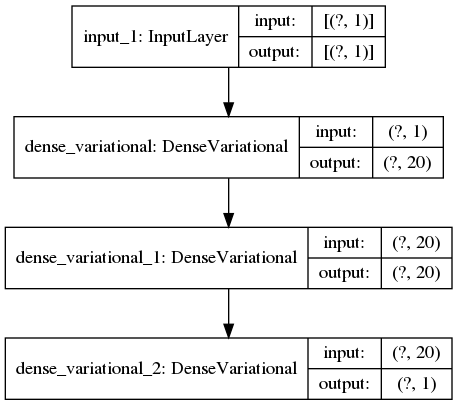

In [9]:
dot_img_file = '/tmp/model_1.png'
tensorflow.keras.utils.plot_model(model, to_file=dot_img_file, show_shapes=True)

The network can now be trained with a Gaussian negative log likelihood function (`neg_log_likelihood`) as loss function assuming a fixed standard deviation (`noise`). This corresponds to the *likelihood cost*, the last term in equation $3$. 

In [10]:
from tensorflow.keras import callbacks, optimizers

def neg_log_likelihood(y_obs, y_pred, sigma=noise):
    dist = tfp.distributions.Normal(loc=y_pred, scale=sigma)
    return K.sum(-dist.log_prob(y_obs))

model.compile(loss=neg_log_likelihood, optimizer=optimizers.Adam(lr=0.08), metrics=['mse'])
history = model.fit(X, y, batch_size=batch_size, epochs=1500, verbose=0);

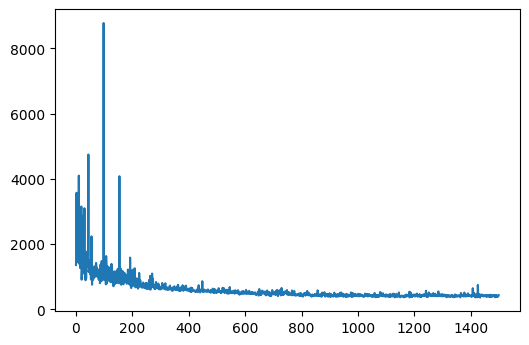

In [11]:
plt.figure(dpi=100)
plt.plot(history.history['loss'])

When calling `model.predict` we draw a random sample from the variational posterior distribution and use it to compute the output value of the network. This is equivalent to obtaining the output from a single member of a hypothetical ensemble of neural networks. Drawing 500 samples means that we get predictions from 500 ensemble members. From these predictions we can compute statistics such as the mean and standard deviation. In our example, the standard deviation is a measure of epistemic uncertainty.

100%|██████████| 500/500 [00:34<00:00, 14.63it/s]


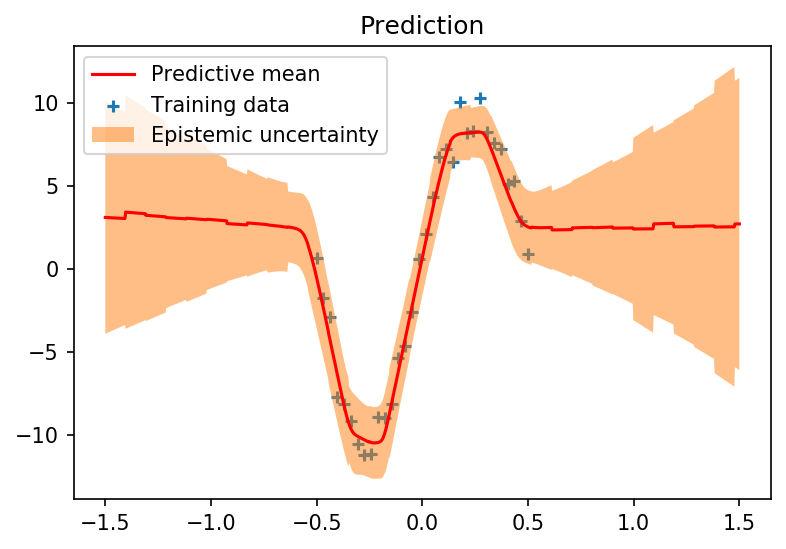

In [12]:
import tqdm

X_test = np.linspace(-1.5, 1.5, 1000).reshape(-1, 1)
y_pred_list = []

for i in tqdm.tqdm(range(500)):
    y_pred = model.predict(X_test)
    y_pred_list.append(y_pred)
    
y_preds = np.concatenate(y_pred_list, axis=1)

y_mean = np.mean(y_preds, axis=1)
y_sigma = np.std(y_preds, axis=1)

plt.figure(dpi=150)
plt.plot(X_test, y_mean, 'r-', label='Predictive mean');
plt.scatter(X, y, marker='+', label='Training data')
plt.fill_between(X_test.ravel(), 
                 y_mean + 2 * y_sigma, 
                 y_mean - 2 * y_sigma, 
                 alpha=0.5, label='Epistemic uncertainty')
plt.title('Prediction')
plt.legend();

We can clearly see that epistemic uncertainty is much higher in regions of no training data than it is in regions of existing training data. The predictive mean could have also been obtained with a single forward pass i.e. a single `model.predict` call by using only the mean of the variational posterior distribution which is equivalent to sampling from the variational posterior with $\boldsymbol{\sigma}$ set to $\mathbf{0}$. The corresponding implementation is omitted here but is trivial to add.

For an example how to model both epistemic and aleatoric uncertainty I recommend reading [Regression with Probabilistic Layers in TensorFlow Probability](https://medium.com/tensorflow/regression-with-probabilistic-layers-in-tensorflow-probability-e46ff5d37baf) which uses probabilistic Keras layers from the upcoming Tensorflow Probability 0.7.0 release. Their approach to variational inference is similar to the approach described here but differs in some details. For example, they compute the complexity cost analytically instead of estimating it from samples, among other differences.

## Appendix

### Optimization objective

The KL divergence between the variational distribution $q(\mathbf{w} \lvert \boldsymbol{\theta})$ and the true posterior $p(\mathbf{w} \lvert \mathcal{D})$ is defined as

$$
\begin{align*}
\mathrm{KL}(q(\mathbf{w} \lvert \boldsymbol{\theta}) \mid\mid p(\mathbf{w} \lvert \mathcal{D})) &=
\int{q(\mathbf{w} \lvert \boldsymbol{\theta}) \log 
    {{q(\mathbf{w} \lvert \boldsymbol{\theta})} \over {p(\mathbf{w} \lvert \mathcal{D})}} d\mathbf{w}} \\\\ &=
\mathbb{E}_{q(\mathbf{w} \lvert \boldsymbol{\theta})} \log
    {{q(\mathbf{w} \lvert \boldsymbol{\theta})} \over {p(\mathbf{w} \lvert \mathcal{D})}}
\end{align*}
$$

Applying Bayes' rule to $p(\mathbf{w} \lvert \mathcal{D})$ we obtain

$$
\begin{align*}
\mathrm{KL}(q(\mathbf{w} \lvert \boldsymbol{\theta}) \mid\mid p(\mathbf{w} \lvert \mathcal{D})) &=
\mathbb{E}_{q(\mathbf{w} \lvert \boldsymbol{\theta})} \log
    {{q(\mathbf{w} \lvert \boldsymbol{\theta})} \over 
     {p(\mathcal{D} \lvert \mathbf{w}) p(\mathbf{w})}} p(\mathcal{D}) \\\\ &=
\mathbb{E}_{q(\mathbf{w} \lvert \boldsymbol{\theta})} \left[
    \log q(\mathbf{w} \lvert \boldsymbol{\theta}) - 
    \log p(\mathcal{D} \lvert \mathbf{w}) - 
    \log p(\mathbf{w}) + 
    \log p(\mathcal{D}) 
\right] \\\\ &=
\mathbb{E}_{q(\mathbf{w} \lvert \boldsymbol{\theta})} \left[
    \log q(\mathbf{w} \lvert \boldsymbol{\theta}) - 
    \log p(\mathcal{D} \lvert \mathbf{w}) - 
    \log p(\mathbf{w})
\right] + \log p(\mathcal{D}) \\\\ &=
\mathrm{KL}(q(\mathbf{w} \lvert \boldsymbol{\theta}) \mid\mid q(\mathbf{w})) - 
\mathbb{E}_{q(\mathbf{w} \lvert \boldsymbol{\theta})} \log p(\mathcal{D} \lvert \mathbf{w}) +
\log p(\mathcal{D})
\end{align*}
$$

using the fact that the *log marginal likelihood* $\log p(\mathcal{D})$ doesn't depend on $\mathbf{w}$. The first two terms on the RHS are the *variational free energy* $\mathcal{F}(\mathcal{D},\boldsymbol{\theta})$ as defined in Eq. $(1)$. We obtain 

$$
\mathrm{KL}(q(\mathbf{w} \lvert \boldsymbol{\theta}) \mid\mid p(\mathbf{w} \lvert \mathcal{D})) =
\mathcal{F}(\mathcal{D},\boldsymbol{\theta}) + \log p(\mathcal{D})
$$

In order to minimize $\mathrm{KL}(q(\mathbf{w} \lvert \boldsymbol{\theta}) \mid\mid p(\mathbf{w} \lvert \mathcal{D}))$ w.r.t. $\boldsymbol{\theta}$ we only need to minimize $\mathcal{F}(\mathcal{D},\boldsymbol{\theta})$ as $p(\mathcal{D})$ doesn't depend on $\boldsymbol{\theta}$. The negative variational free energy is also known as *evidence lower bound* $\mathcal{L}(\mathcal{D},\boldsymbol{\theta})$ (ELBO). 

$$
\mathrm{KL}(q(\mathbf{w} \lvert \boldsymbol{\theta}) \mid\mid p(\mathbf{w} \lvert \mathcal{D})) =
-\mathcal{L}(\mathcal{D},\boldsymbol{\theta}) + \log p(\mathcal{D})
$$

It is a lower bound on $\log p(\mathcal{D})$ because the Kullback-Leibler divergence is always non-negative.

$$
\begin{align*}
\mathcal{L}(\mathcal{D},\boldsymbol{\theta}) &= 
\log p(\mathcal{D}) - \mathrm{KL}(q(\mathbf{w} \lvert \boldsymbol{\theta}) \mid\mid p(\mathbf{w} \lvert \mathcal{D})) \\\\
\mathcal{L}(\mathcal{D},\boldsymbol{\theta}) &\leq
\log p(\mathcal{D})
\end{align*}
$$

Therefore, the KL divergence between the variational distribution $q(\mathbf{w} \lvert \boldsymbol{\theta})$ and the true posterior $p(\mathbf{w} \lvert \mathcal{D})$ is also minimized by maximizing the evidence lower bound.